# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

### Установка библиотек и настройка окружения

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import shap

from IPython.display import display

from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

import scipy
import scipy.stats as stats
from scipy.stats import poisson

import phik
from phik import resources, report

warnings.filterwarnings('ignore')

c:\Users\eprutskoy\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\eprutskoy\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

### Инициализация полезных функций

In [3]:
def get_stratified_sample(data, stratify_column='column_for_stratification', sample_size=100000):
    """
    Возвращает случайные sample_size строк из датафрейма data, сохраняя пропорциональное представление значений в stratify_column.
    
    Parameters:
    data (pd.DataFrame): Исходный датафрейм.
    stratify_column (str): Название колонки, по которой нужно стратифицировать выборку.
    sample_size (int): Размер выборки.
    
    Returns:
    pd.DataFrame: Датафрейм, содержащий случайную стратифицированную выборку указанного размера.
    """
    # Разделение данных на "обучающий" набор (который будет отброшен) и "тестовый" набор, который является нужной выборкой
    _, data_sample = train_test_split(data, test_size=sample_size, stratify=data[stratify_column], random_state=42)
    
    return data_sample

In [4]:
class DatasetSizeTracker:
    def __init__(self):
        self.initial_size = None
        self.previous_size = None

    def track(self, data):
        # Если исходный размер не был установлен, запоминаем его и текущий размер как первоначальный
        if self.initial_size is None:
            self.initial_size = len(data)
            self.previous_size = len(data)
            loss_from_initial = 0
            loss_from_previous = 0
            loss_percent_overoll = 0
        else:
            # Считаем, сколько строк потеряно относительно исходного размера и с прошлого вызова
            current_size = len(data)
            loss_from_initial = self.initial_size - current_size
            loss_from_previous = self.previous_size - current_size
            loss_percent_overoll = ((self.initial_size - current_size)/self.initial_size)*100
            # Обновляем предыдущий размер для следующего вызова
            self.previous_size = current_size
        
        return {"Потери от исходного размера": loss_from_initial, "Потери с предыдущего раза": loss_from_previous,
                'Общие потери в процентах' : loss_percent_overoll}

# Создание экземпляра класса для трекинга размера датасета
tracker = DatasetSizeTracker()

In [5]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    # Вывод статистического описания
    print("\n Статистическое описание:")
    display(df.describe().transpose())

    # Вывод случайных примеров
    print("\nСлучайные примеры:")
    display(df.sample(5))

    # Вывод количества строк и столбцов
    print("\nКоличество строк и столбцов:", df.shape)
    
    # Вывод количества явных дубликатов
    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [6]:
# функция поиска пропусков
def analyze_missing_values(df, string):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {string}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {string}")
        plt.show()

In [7]:
# Функция для преобразования названий в змеиный регистр (snake_case) 
def to_snake_case(name): 
    s1 = name[0].lower() 
    for c in name[1:]: 
        if c.isupper(): 
            s1 += '_' 
            s1 += c.lower() 
        else: 
            s1 += c 
    return s1 
 

In [8]:
def fill_missing_values_by_brand_and_model(data, column_name):
    """
    Заполняет пропуски в указанной колонке на основе самого частого значения,
    характерного для сгруппированных данных по 'brand' и 'model'.
    
    Parameters:
    data (pd.DataFrame): Исходный датафрейм.
    column_name (str): Название колонки, в которой нужно заполнить пропуски.
    
    Returns:
    pd.DataFrame: Датафрейм с заполненными пропусками в указанной колонке.
    """
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if pd.isnull(row[column_name]):
            return most_frequent_values.get((row['brand'], row['model']), row[column_name])
        else:
            return row[column_name]
    
    # Заполнение пропусков
    data[column_name] = data.apply(fill_value, axis=1)
    
    return data

### Обзор данных, работа с дубликатами, пропусками и выбросами

План работы:
1) Анализ описательной статитстики по данным;
2) Очистка явных дубликатов;
3) Обработка пропусков;
4) Обработка выбросов;
5) Анализ визуальной статистики.

#### Обзор данных

In [9]:
data = pd.read_csv('autos.csv')

# Создадим отдельный датасет, который мы оставим в исходном состоянии. 
# Все необходимые преобразования
# data_model = data.copy()

In [10]:
# Для использования функции, укажите DataFrame, колонку для стратификации и желаемый размер выборки:
data = get_stratified_sample(data, 'Brand', 150000)

In [11]:
dataframe_summary(data, 'Автомобили (data)')

Общая информация по таблице: Автомобили (data)
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 160315 to 305182
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        150000 non-null  object
 1   Price              150000 non-null  int64 
 2   VehicleType        134018 non-null  object
 3   RegistrationYear   150000 non-null  int64 
 4   Gearbox            141624 non-null  object
 5   Power              150000 non-null  int64 
 6   Model              141599 non-null  object
 7   Kilometer          150000 non-null  int64 
 8   RegistrationMonth  150000 non-null  int64 
 9   FuelType           135984 non-null  object
 10  Brand              150000 non-null  object
 11  Repaired           119923 non-null  object
 12  DateCreated        150000 non-null  object
 13  NumberOfPictures   150000 non-null  int64 
 14  PostalCode         150000 non-null  int64 
 15  LastSeen           15

,count,mean,std,min,25%,50%,75%,max
Price,"150,000.00","4,403.21","4,497.12",0.00,"1,050.00","2,700.00","6,390.00","20,000.00"
RegistrationYear,"150,000.00","2,003.86",74.56,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"150,000.00",110.28,196.23,0.00,69.00,105.00,141.00,"20,000.00"
Kilometer,"150,000.00","128,305.50","37,843.45","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"150,000.00",5.71,3.72,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"150,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"150,000.00","50,463.42","25,799.89","1,067.00","30,161.00","49,377.00","71,065.00","99,998.00"



Случайные примеры:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
137101,2016-03-29 21:39:15,10890,wagon,2007,auto,272,e_klasse,150000,7,petrol,mercedes_benz,NaN,2016-03-29 00:00:00,0,82362,2016-04-06 07:46:22
47878,2016-04-01 13:50:14,999,small,2002,manual,75,clio,150000,5,petrol,renault,no,2016-04-01 00:00:00,0,73730,2016-04-01 13:50:14
205690,2016-03-26 12:51:53,8500,bus,2009,manual,110,berlingo,150000,12,gasoline,citroen,no,2016-03-26 00:00:00,0,39108,2016-03-31 07:46:09
21875,2016-03-24 20:58:22,1350,sedan,1998,manual,101,passat,150000,9,petrol,volkswagen,no,2016-03-24 00:00:00,0,38530,2016-03-26 06:47:23
77387,2016-03-10 00:48:54,1950,other,1984,manual,34,kaefer,150000,12,petrol,volkswagen,no,2016-03-09 00:00:00,0,27476,2016-03-10 16:49:31



Количество строк и столбцов: (150000, 16)

Количество явных дубликатов: 2



In [12]:
tracker = DatasetSizeTracker()

tracker.track(data)  # Посмотреть, сколько строк потеряно с исходного момента и с последнего вызова

{'Потери от исходного размера': 0,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 0}

Изменим названия переменных, избавимся от дубликатов

In [13]:
data.columns = [to_snake_case(name) for name in data.columns] 
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [14]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)

В данных есть объявления с ценой равной 0. Тк это целевой признак - менять нельзя, но лучше удалить строки с такой ценой.

In [15]:
print('Сколько людей готовы "подарить" автомобиль:',len(data.loc[data['price'] == 0]))
data = data.loc[data['price'] != 0]
print('Сколько людей готовы "подарить" автомобиль теперь:',len(data.loc[data['price'] == 0]))

Сколько людей готовы "подарить" автомобиль: 4495
Сколько людей готовы "подарить" автомобиль теперь: 0


In [16]:
tracker.track(data) 

{'Потери от исходного размера': 4497,
 'Потери с предыдущего раза': 4497,
 'Общие потери в процентах': 2.9979999999999998}

Пропуски в датафрейме data:
              Total  Percent
repaired      27876    19.16
vehicle_type  14437     9.92
fuel_type     12622     8.67
model          7501     5.16
gearbox        7378     5.07



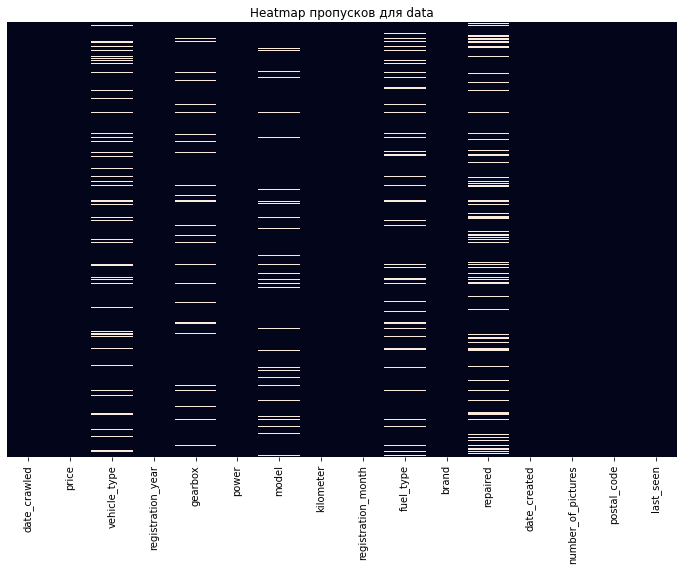

In [17]:
analyze_missing_values(data, 'data')

Избавимся от явных дубликатов, возможно, после обработки датасета и удаления ненужных переменных дубликатов станет больше.

In [18]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis =1) 

In [19]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [20]:
display(data[['brand', 'model','vehicle_type', 'fuel_type', 'gearbox', 'power' ,'repaired','price']].sample(10))

,brand,model,vehicle_type,fuel_type,gearbox,power,repaired,price
283640,renault,twingo,small,petrol,manual,58,no,275
279572,bmw,3er,sedan,petrol,manual,143,no,2500
152159,opel,astra,sedan,petrol,manual,75,no,2200
194042,volkswagen,passat,wagon,gasoline,manual,150,no,2250
249380,bmw,3er,small,petrol,manual,118,no,2350
40192,citroen,other,sedan,petrol,manual,75,NaN,300
219414,volkswagen,golf,NaN,gasoline,manual,116,yes,1299
318990,volvo,other,sedan,petrol,manual,75,no,9500
209674,bmw,3er,sedan,NaN,manual,150,NaN,1700
215302,fiat,500,sedan,petrol,manual,99,no,5500


#### Работа с пропусками

##### Пропуски в `model`

Пропуски в `model`, на мой взгляд, критичны. Фактор модели может играть значительную роль в определении цены машины. Восполнить пропуски здесь никак, заглушка тоже может в данном случае не подойти или нарушить связи. 

In [21]:
data = data.loc[~data['model'].isna()]
tracker.track(data) 

{'Потери от исходного размера': 11998,
 'Потери с предыдущего раза': 7501,
 'Общие потери в процентах': 7.998666666666667}

##### Пропуски в `repaired`

Пропусков в repaired довольно много, порядка 20% от изначального размера данных.\
Фактор довольно важный, при написании объявления обязательно указывать, если машина ремонтировалась. Возможно, значения в этом столбце пропущены, если машина не чинилась и продавцы оставляли незаполненным этот пропуск. \
Если качество модели будет неудовлетворительным, можно попробовать применить заглушку.


In [22]:
data.repaired.value_counts()

repaired
no     99857
yes    13523
Name: count, dtype: int64

In [23]:
data.repaired.fillna('no', inplace=True)

Пропуски в датафрейме data:
              Total  Percent
vehicle_type  12065     8.74
fuel_type     10076     7.30
gearbox        6029     4.37



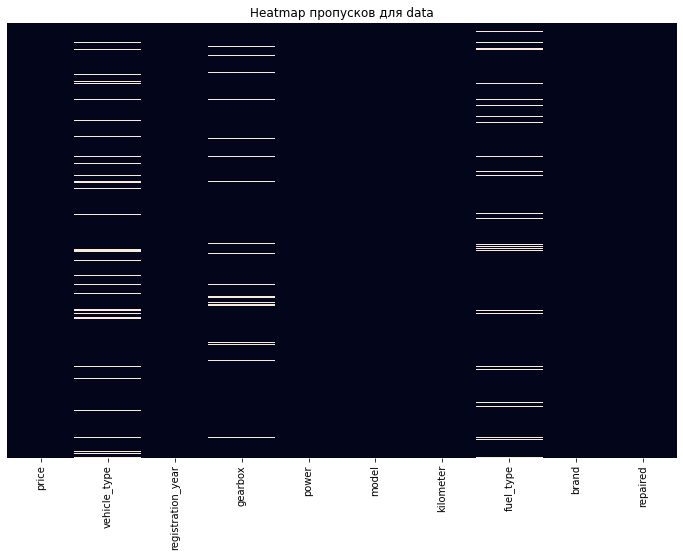

In [24]:
analyze_missing_values(data, 'data')

Остались пропуски в `vehicle_type`,  `fuel_type` и `gearbox` - их заполним на основе данных из `model` и `brand`. 

In [25]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          36542
small          31559
wagon          26143
bus            11652
convertible     8013
coupe           6285
suv             4627
other           1116
Name: count, dtype: int64
fuel_type
petrol      85495
gasoline    39976
lpg          2037
cng           233
hybrid        110
other          46
electric       29
Name: count, dtype: int64
gearbox
manual    105831
auto       26142
Name: count, dtype: int64


In [26]:
# используем функцию для заполнения пропусков на основе сгрупиированных данных по brand и model
missing_list = ['vehicle_type', 'fuel_type', 'gearbox']
for i in missing_list:
    data = fill_missing_values_by_brand_and_model(data, i)


In [27]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          41465
small          35173
wagon          27584
bus            13091
convertible     8151
coupe           6538
suv             4883
other           1117
Name: count, dtype: int64
fuel_type
petrol      93645
gasoline    41902
lpg          2037
cng           233
hybrid        110
other          46
electric       29
Name: count, dtype: int64
gearbox
manual    111086
auto       26916
Name: count, dtype: int64


#### Обработка аномальных значений

In [28]:
data.describe()

,price,registration_year,power,kilometer
count,"138,002.00","138,002.00","138,002.00","138,002.00"
mean,"4,611.23","2,003.84",112.27,"128,648.24"
std,"4,516.39",59.78,190.68,"36,959.39"
min,1.00,"1,000.00",0.00,"5,000.00"
25%,"1,200.00","1,999.00",72.00,"125,000.00"
50%,"2,950.00","2,003.00",105.00,"150,000.00"
75%,"6,600.00","2,008.00",143.00,"150,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"


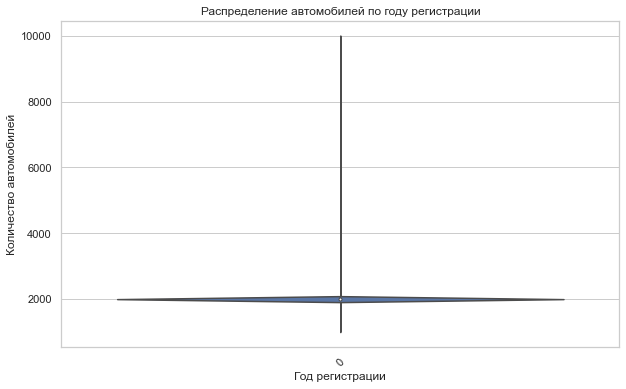

In [29]:
# Установка стиля для графиков
sns.set(style="whitegrid")

# Создание графика распределения значений по годам
plt.figure(figsize=(10, 6))  # Установка размера фигуры
sns.violinplot(data['registration_year'])

plt.title('Распределение автомобилей по году регистрации')  # Заголовок графика
plt.xlabel('Год регистрации')  # Подпись оси X
plt.ylabel('Количество автомобилей')  # Подпись оси Y
plt.xticks(rotation=45)  # Поворот меток на оси X для лучшего отображения

plt.show() 

В данном столбце много выбросов, обработаем выбивающиеся значения. \
Границы отбора данных на изменение предлагаю определить такие:
 * Верхний потолок - 2024 год (машины из 2025года+ пока не производят, к сожалению не придумали)
 * Нижний потолок - машины старше 1980 года. Машин с более поздним годом выпуска совсем немного. 

In [30]:
print(f"Строки с годом регистрации до 1980 или после 2024 составляют {(len(data[(data['registration_year'] < 1980) |  (data['registration_year'] > 2024)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с годом регистрации до 1980 или после 2024 составляют 0.75% от всего датасета.


In [31]:
tracker.track(data) 

{'Потери от исходного размера': 11998,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 7.998666666666667}

In [32]:
data = data[(data['registration_year'] >= 1985) & (data['registration_year'] <= 2024)]

In [33]:
tracker.track(data) 

{'Потери от исходного размера': 13710,
 'Потери с предыдущего раза': 1712,
 'Общие потери в процентах': 9.139999999999999}

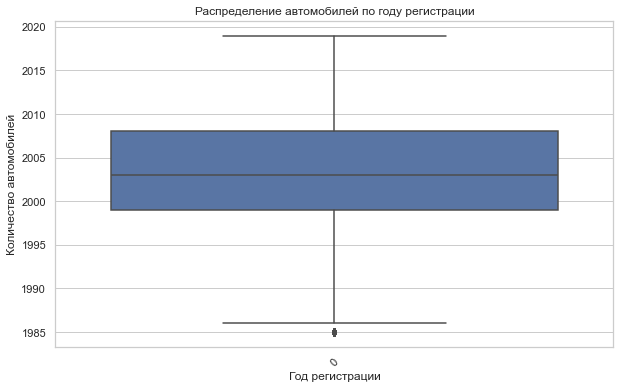

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['registration_year'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

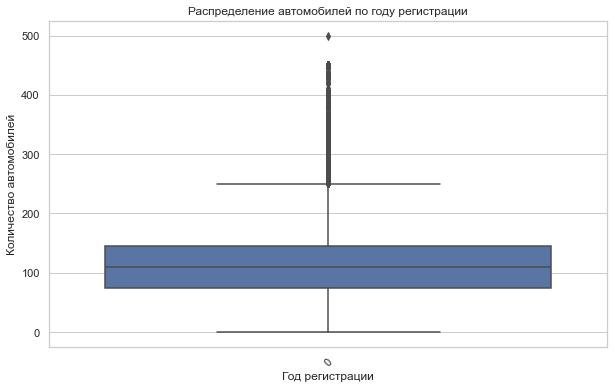

In [39]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [38]:
print(f"Строки с слишком большой или малой мощностью составляют {(len(data[(data['power'] < 45) |   (data['power'] > 450)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с слишком большой или малой мощностью составляют 0.82% от всего датасета.


In [87]:
data_grp = data.groupby(['brand', 'model', 'vehicle_type'])['power'].apply(lambda x: x.median())

In [36]:
def replace_outliers(data, column_name):
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model', 'vehicle_type'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if row['power'] < 45 or row['power'] > 450:
            return most_frequent_values.get((row['brand'], row['model'], row['vehicle_type']), row[column_name])
        else:
            return row[column_name]
    
    # Заполнение пропусков
    data[column_name] = data.apply(fill_value, axis=1)

    return data

In [37]:
replace_outliers(data, 'power')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
160315,799,sedan,1998,manual,75,colt,150000,petrol,mitsubishi,no
266699,2900,sedan,2001,auto,170,e_klasse,150000,petrol,mercedes_benz,no
40687,1995,small,2009,manual,75,sandero,10000,petrol,dacia,yes
34216,11800,wagon,2013,manual,131,megane,30000,petrol,renault,no
248075,2999,suv,1994,auto,184,cherokee,150000,petrol,jeep,no
99116,1800,small,2000,manual,75,polo,125000,petrol,volkswagen,no
75285,16450,sedan,2013,manual,140,leon,20000,petrol,seat,no
186944,590,small,1998,manual,45,corsa,150000,petrol,opel,no
159314,2299,wagon,1999,manual,101,golf,150000,petrol,volkswagen,no
149488,12500,bus,1999,manual,180,transporter,150000,gasoline,volkswagen,no


In [40]:
data = data[(data['power'] <= 450) & (data['power'] >= 45)]

tracker.track(data) 

{'Потери от исходного размера': 14829,
 'Потери с предыдущего раза': 1119,
 'Общие потери в процентах': 9.886000000000001}

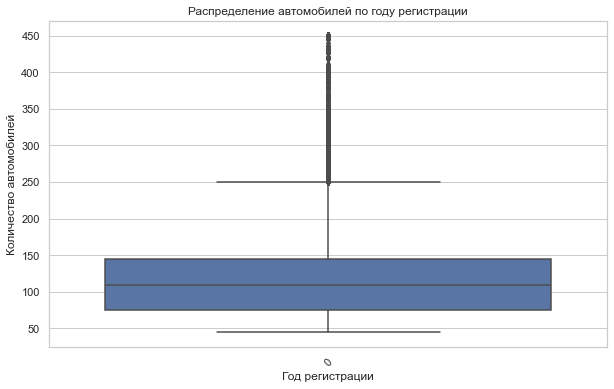

In [41]:
replace_outliers(data, 'power')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [95]:
dataframe_summary(data, 'data')

Общая информация по таблице: data
<class 'pandas.core.frame.DataFrame'>
Index: 319204 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319204 non-null  int64 
 1   vehicle_type       319204 non-null  object
 2   registration_year  319204 non-null  int64 
 3   gearbox            319204 non-null  object
 4   power              319204 non-null  int64 
 5   model              319204 non-null  object
 6   kilometer          319204 non-null  int64 
 7   fuel_type          319204 non-null  object
 8   brand              319204 non-null  object
 9   repaired           319204 non-null  object
dtypes: int64(4), object(6)
memory usage: 34.9+ MB

 Статистическое описание:


,count,mean,std,min,25%,50%,75%,max
price,"319,204.00","4,620.54","4,525.41",1.00,"1,200.00","2,950.00","6,600.00","20,000.00"
registration_year,"319,204.00","2,003.64",6.24,"1,985.00","1,999.00","2,003.00","2,008.00","2,019.00"
power,"319,204.00",118.96,51.93,45.00,75.00,110.00,147.00,450.00
kilometer,"319,204.00","129,039.34","36,481.41","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"



Случайные примеры:


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
189977,5500,sedan,2007,manual,185,s60,150000,gasoline,volvo,no
125578,15300,sedan,2010,auto,190,a6,150000,gasoline,audi,no
38948,1500,small,2001,manual,60,lupo,150000,gasoline,volkswagen,no
37123,1,convertible,2000,manual,107,megane,150000,petrol,renault,no
303816,11900,sedan,2005,manual,150,x_reihe,150000,gasoline,bmw,no



Количество строк и столбцов: (319204, 10)

Количество явных дубликатов: 56647



## Обучение моделей

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей